# Exploring 1D polynomial interpolation in Python with SciPy

Interpolation is the process of estimating unknown values that fall between known data points. In 1D interpolation, we have a set of known data points $(x_i, y_i)$ and we want to find a function $f(x)$ such that $f(x_i) = y_i$ for all $i$, and which we can use to estimate $y$ for any $x$ between the known $x_i$.

---

## 1. Setup: Importing libraries and setting up helper functions

First, let's import the necessary libraries. We'll need `numpy` for numerical operations (especially creating arrays), `matplotlib.pyplot` for plotting our results, and various functions/classes from `scipy.interpolate`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import (
    BarycentricInterpolator,   barycentric_interpolate,
    KroghInterpolator,         krogh_interpolate,
    lagrange
)

np.set_printoptions(linewidth=200)

Let us define some helper functions for plotting:

In [2]:
def plot_interpolation(x_known, y_known, x_eval, y_eval, title, true_func=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x_known, y_known, 'ro', label='Known Data Points', markersize=8)
    plt.plot(x_eval,  y_eval,  'b-', label='Interpolated Curve')
    if true_func:
        plt.plot(x_eval, true_func(x_eval), 'g--', label='True Function', alpha=0.7)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_comparison(x_known, y_known, x_eval, methods_dict, title):
    plt.figure(figsize=(12, 8))
    plt.plot(x_known, y_known, 'ro', label='Known Data Points', markersize=10, zorder=10)

    for name, y_eval in methods_dict.items():
        plt.plot(x_eval, y_eval, label=name, alpha=0.8)

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.draw()

Let us define the datasets:

In [3]:
# --- Smooth Data ---
x_smooth = np.linspace(0, 10, 10)
y_smooth = np.sin(x_smooth)
x_eval_smooth = np.linspace(0, 10, 100)

# --- Runge Function Data ---
runge_func = lambda x : 1/(1 + 25*x**2)
x_runge = np.linspace(-1, 1, 11)
y_runge = runge_func(x_runge)
x_eval_runge = np.linspace(-1, 1, 200)

## 2. Polynomial interpolation

These methods attempt to find a *single* polynomial that passes exactly through *all* the data points. While mathematically elegant, they can suffer from **Runge's phenomenon** – wild oscillations near the edges, especially when using a high number of equally spaced points.

## `lagrange`
Returns the coefficients of the Lagrange interpolating polynomial.

According to the documentation, **this implementation is numerically unstable. Do not expect to be able to use more than about 20 points even if they are chosen optimally.**

## `KroghInterpolator`
Uses the Newton form of the interpolating polynomial. It's particularly useful when you also know the derivatives at the data points, which is useful in mechanics problems (e.g., specifying a zero slope at a fixed support).

* **Strengths**: Can incorporate derivative information, exact fit.
* **Weaknesses**: Very prone to Runge's phenomenon, can be computationally expensive for high degrees.

## `BarycentricInterpolator`
This method computes the *same* oscillating polynomial as Krogh's method, but using a more numerically stable formula called the barycentric form.

Uses the barycentric form of the interpolating polynomial. It's generally more numerically stable and efficient for evaluation than the standard or Newton forms. *(Note: FloaterHormann is a type of barycentric rational interpolation, but SciPy primarily offers this polynomial version).*

* **Strengths**: Numerically stable, efficient evaluation, easy to update points.
* **Weaknesses**:  Suffers from the exact same Runge's phenomenon as KroghInterpolator. It's just a different algorithm to get the same bad result.


### Functional Forms (`krogh_interpolate`, `barycentric_interpolate`)
These are one-shot functions for evaluating the interpolant at specific points without creating an interpolator object. They are less efficient if you need to evaluate the same interpolant many times.


Lagrange interpolating poly L(x):
            9             8             7           6          5
4.896e-07 x - 3.536e-05 x + 0.0009221 x - 0.01149 x + 0.0718 x
           4          3          2
 - 0.2066 x + 0.2251 x - 0.3934 x + 1.158 x 

Lagrange interpolating poly L(x):
 0.0 + 1.15761009·x - 0.39340968·x² + 0.22505434·x³ - 0.20659959·x⁴ + 0.07179731·x⁵ - 0.01148593·x⁶ + 0.00092212·x⁷ - (3.53649233e-05)·x⁸ + (4.89627849e-07)·x⁹ 

Difference Krogh Class vs Func:       0.00e+00
Difference Barycentric Class vs Func: 7.77e-16


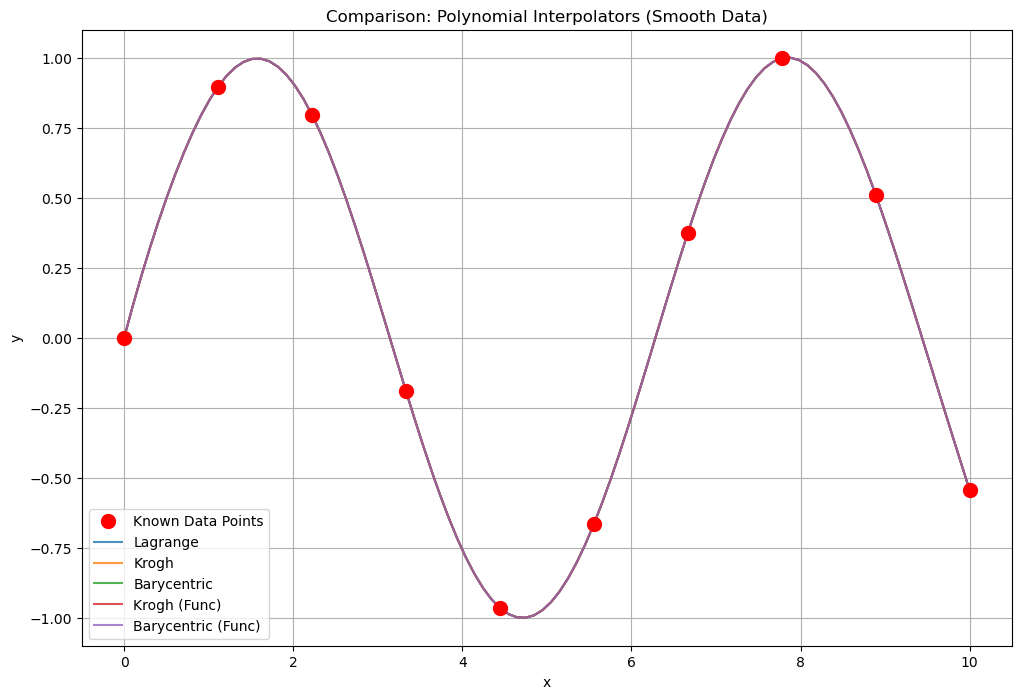

In [4]:
# --- Lagrange ---
L = lagrange(x_smooth, y_smooth)
y_lagrange = L(x_eval_smooth)
print("Lagrange interpolating poly L(x):\n", L, '\n')
print("Lagrange interpolating poly L(x):\n", np.polynomial.Polynomial(np.flip(L)), '\n')

# --- Krogh ---
krogh_interpolator = KroghInterpolator(x_smooth, y_smooth)
y_krogh = krogh_interpolator(x_eval_smooth)

# --- Barycentric ---
bary_interpolator = BarycentricInterpolator(x_smooth, y_smooth)
y_bary = bary_interpolator(x_eval_smooth)

# --- Functional Forms ---
y_krogh_func = krogh_interpolate(x_smooth, y_smooth, x_eval_smooth)
y_bary_func  = barycentric_interpolate(x_smooth, y_smooth, x_eval_smooth)

# --- Comparison ---
comparison_dict = {
    'Lagrange':           y_lagrange,         
    'Krogh':              y_krogh,
    'Barycentric':        y_bary,
    'Krogh (Func)':       y_krogh_func,
    'Barycentric (Func)': y_bary_func,
}
plot_comparison(x_smooth, y_smooth, x_eval_smooth, comparison_dict,
                'Comparison: Polynomial Interpolators (Smooth Data)')

# Check differences (should be tiny)
print(f"Difference Krogh Class vs Func:       {np.max(np.abs(y_krogh - y_krogh_func)):.2e}")
print(f"Difference Barycentric Class vs Func: {np.max(np.abs(y_bary  - y_bary_func)) :.2e}")

## Runge's Phenomenon

Let's see how `BarycentricInterpolator` behaves with the Runge function data. Notice the wild oscillations near -1 and 1. This highlights the main weakness of high-degree global polynomial interpolation.


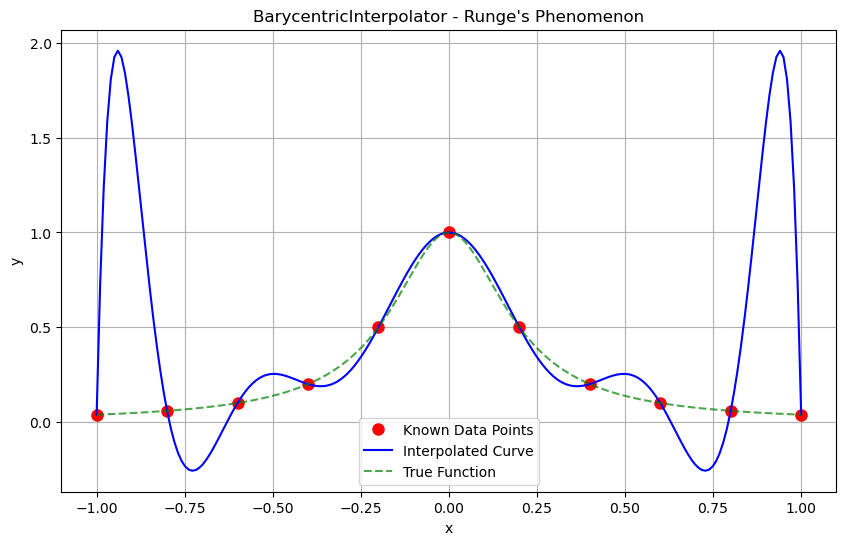

In [5]:
bary_runge = BarycentricInterpolator(x_runge, y_runge)
y_bary_runge = bary_runge(x_eval_runge)
plot_interpolation(x_runge, y_runge, x_eval_runge, y_bary_runge,
                   "BarycentricInterpolator - Runge's Phenomenon",
                   true_func=runge_func)